In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.insert(0,'../')

In [ ]:
from mllib.nlp.datasets.cmudict import CMUDict
from datasets import load_dataset
from mllib.nlp.seq2seq import Seq2Seq

In [ ]:
ds = load_dataset('/notebooks/dlnotebooks/mllib/nlp/datasets/cmudict.py')

Reusing dataset cmu_dict (/root/.cache/huggingface/datasets/cmu_dict/cmu3/1.0.0/a0e598136ef9603a0d6d97059f5e1d2cac789cfe3c0998cb2b4b7fd4198da504)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
train_test = ds['train'].train_test_split(test_size=0.2)

Loading cached split indices for dataset at /root/.cache/huggingface/datasets/cmu_dict/cmu3/1.0.0/a0e598136ef9603a0d6d97059f5e1d2cac789cfe3c0998cb2b4b7fd4198da504/cache-b2d95f15faaf4500.arrow and /root/.cache/huggingface/datasets/cmu_dict/cmu3/1.0.0/a0e598136ef9603a0d6d97059f5e1d2cac789cfe3c0998cb2b4b7fd4198da504/cache-5ed2c4bc219f1934.arrow


In [ ]:
train_test['train'][0]

{'word': 'preempted',
 'word_length': 9,
 'phoneme': ['P', 'R', 'IY0', 'EH1', 'M', 'P', 'T', 'IH0', 'D']}

# Data Processing

Processing data with map inspired by `tf.dataset.map` map method 

In [ ]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator



In [ ]:
phoneme_vocab = build_vocab_from_iterator(train_test['train']['phoneme'],specials=['<unk>','<sos>'])
word_vocab = build_vocab_from_iterator(train_test['train']['word'],specials=['<unk>'])

In [ ]:
phoneme_vocab(['<unk>','<sos>'])

[0, 1]

In [ ]:
phoneme_vocab.set_default_index(0)
word_vocab.set_default_index(0)

In [ ]:
word_vocab.lookup_indices(['a','b','c'])

[2, 17, 10]

# Data pipelines

In [ ]:
BATCH_SIZE = 8

In [ ]:
src_pipeline = lambda data: word_vocab.lookup_indices(list(data))
trg_pipeline = lambda data: phoneme_vocab.lookup_indices(data)
    
    

### Prepare for manual inputs

In [ ]:
from datasets import Dataset

# from python dictionary
my_dict = {
    'word': ['puneet','mike'],
    'word_length': [6,4],
    'phoneme': [['P','N','T'],['M','K']]
}

dummy_dataset= Dataset.from_dict(my_dict)


In [ ]:
from torch.utils.data import DataLoader
def pad_collate(batch):
    items= [ (src_pipeline(items['word']), 
             trg_pipeline(items['phoneme']), 
              items['word_length']) for items in batch
           ]
    
    def pad(xs, ind):
        xs = [torch.tensor(x[ind]) for x in xs]
        return torch.nn.utils.rnn.pad_sequence(xs, batch_first=True)

    return {
        'src': pad(items, 0),
        'trg' : pad(items, 1),
        'src_len' : torch.tensor([x[2] for x in items])
    }

In [ ]:
dls = DataLoader(train_test['train'], shuffle=True, collate_fn=pad_collate, batch_size=32)

In [ ]:
from transformers import DataCollatorWithPadding, default_data_collator

### Testing

In [ ]:
import random
# checking
def decode_word(lst):
    return ''.join(word_vocab.lookup_tokens(lst.numpy()))

def decode_phoneme(lst):
    return ','.join(phoneme_vocab.lookup_tokens(lst.numpy()))

decoder_funs={
    'src': decode_word,
    'trg': decode_phoneme
}

batch=next(iter(dls))


for k,v in batch.items():
    print('---'*24)
    count = 5
    for i in range(len(v)):
        if count == 0:
            continue
        if k in decoder_funs:
            print(k, decoder_funs[k](v[i]))
        else:
            print(k,v[i])
            
        count -= 1

------------------------------------------------------------------------
src irell<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>
src catanzaro<unk><unk><unk><unk><unk><unk>
src nayden<unk><unk><unk><unk><unk><unk><unk><unk><unk>
src lucie<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>
src moore<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>
------------------------------------------------------------------------
trg AY0,R,EH1,L,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>
trg K,AA0,T,AA0,N,Z,AA1,R,OW0,<unk>,<unk>,<unk>,<unk>,<unk>
trg N,EY1,D,IH0,N,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>
trg L,UW1,S,IY0,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>
trg M,UH1,R,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>,<unk>
------------------------------------------------------------------------
src_len tensor(5)
src_len tensor(9)
src_len tensor(6)
src_len tensor(5)
src_len tensor(5)


# Model building

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import NeptuneLogger

# create NeptuneLogger
neptune_logger = NeptuneLogger(
    api_key = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIwYWY0OTQ4MS03MGY4LTRhNjUtOTFlZC0zZjVjMjlmZGQxNjQifQ==",

    project_name='puneetgirdhar.in/seq2seq',  # "<WORKSPACE/PROJECT>"
    tags=["seq2seq"],  # optional
)

NeptuneLogger will work in online mode


In [ ]:

MAX_EPOCHS=5

In [ ]:
from pytorch_lightning.callbacks import Callback

In [ ]:
# def evalute(encoder, decoder, sentence, max_length=MAX_LENGTH):
#     with torch.no_grad():
#         input_tensor = tensorFromSentence(sentence)
#         input_length = input_tensor.size()[0]
        
#         decoder_input = torch.ones().to(device)

In [ ]:
class EvaluationCallback(Callback):
    def __init__(self, num_samples:int = 3, max_length:int=10, pad_idx:int = 0):
        self.num_samples = num_samples
        
        self.pad_idx = pad_idx
        self.examples  = {
        'word': ['puneet','mike'],
        'word_length': [6,4],
        'phoneme': [['P','N','T','P','T','S'],['M','K']]
        }
        
        
        self.max_length = max_length
    
    def setup(self,trainer, model, stage):
        dummy_dataset= Dataset.from_dict(self.examples)
        
        self.dls = DataLoader(dummy_dataset, shuffle=True, collate_fn = pad_collate, batch_size=4)
        self.batch = next(iter(self.dls))
        
    def on_epoch_end(self,trainer,pl_module)->None:

        input_seq = self.batch['src'].cuda()
        target_seq =  self.batch['trg'].cuda()
        src_len = self.batch['src_len'].cuda()
        output = pl_module(input_seq, src_len, target_seq)
        
        output = output.permute(1, 0,2) # batch x seq_len x output_dim
        
        topv, topi = output.topk(1,dim=-1)
        # topi will be seq_lenx batch x output_dim
        
        topi= topi.squeeze(dim=-1)
        for b in range(topi.shape[0]):
            result = decode_phoneme(topi[b].cpu())
            print(result)

In [ ]:
lr_monitor = LearningRateMonitor(logging_interval='step')
ec = EvaluationCallback()
logger = TensorBoardLogger('tb_logs', name='my_model')
trainer = pl.Trainer(callbacks=[lr_monitor, ec],max_epochs=MAX_EPOCHS, gpus=1, logger=[neptune_logger])

find_trainer = pl.Trainer(auto_lr_find=True)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
GPU available: True, used: False
TPU available: None, using: 0 TPU cores


In [ ]:
trainer.fit(model, train_dataloader=dls)

https://app.neptune.ai/puneetgirdhar.in/seq2seq/e/SEQ-4



  | Name    | Type             | Params
---------------------------------------------
0 | _loss   | CrossEntropyLoss | 0     
1 | encoder | Encoder          | 14.0 K
2 | decoder | NewDecoder       | 17.3 K
---------------------------------------------
31.3 K    Trainable params
0         Non-trainable params
31.3 K    Total params
0.125     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

In [ ]:
input_vocab_size = len(word_vocab)
output_vocab_size  = len(phoneme_vocab)

model = Seq2Seq(input_vocab_size, output_vocab_size,p=0.1,max_epochs=MAX_EPOCHS)

In [ ]:
lr_finder = find_trainer.tuner.lr_find( model, train_dataloader=dls )

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name    | Type             | Params
---------------------------------------------
0 | _loss   | CrossEntropyLoss | 0     
1 | encoder | Encoder          | 14.0 K
2 | decoder | NewDecoder       | 17.3 K
---------------------------------------------
31.3 K    Trainable params
0         Non-trainable params
31.3 K    Total params
0.125     Total estimated model params size (MB)
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /notebooks/dlnotebooks/nbs/lr_find_temp_model.ckpt


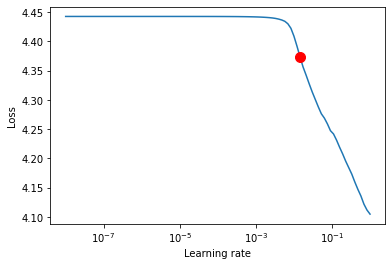

In [ ]:
#lr_finder.results
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
model.hparams.lr = new_lr

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:51: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)


TypeError: setup() takes 1 positional argument but 4 were given

In [ ]:
#trainer.save_checkpoint('model.ckpt')

# Prediction

Here we will test the model to check if it has been trained well or not.

In [ ]:
model = Seq2Seq.load_from_checkpoint('model.ckpt')

In [ ]:
print(model.learning_rate)

0.0005
